In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.applications.resnet50 import preprocess_input

#tf.enable_eager_execution()

In [8]:
resnet_50 = tf.keras.applications.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

In [24]:
import os
from PIL import Image
import cv2

class_path = "/data1/Henry/valid/airplane"

imgs = []

for i in range(15):
    path = os.path.join(class_path, os.listdir(class_path)[i])
    img = cv2.imread(path)[:,:,::-1]
    img = cv2.resize(img, (224, 224))
    imgs.append(img)


In [10]:
def preprocess(img):
    # use the pre processing function of ResNet50 
    img = preprocess_input(img)

    #expand the dimension
    return np.expand_dims(img, 0)

In [11]:
def get_activations_at(input_image, i):
    #index the layer 
    out_layer = resnet_50.layers[i]

    #change the output of the model 
    model = tf.keras.models.Model(inputs = resnet_50.inputs, outputs = out_layer.output)

    #return the activations
    return model.predict(input_image)

In [12]:
def postprocess_activations(activations):

    #using the approach in https://arxiv.org/abs/1612.03928
    output = np.abs(activations)
    output = np.sum(output, axis = -1).squeeze()

    #resize and convert to image 
    output = cv2.resize(output, (224, 224))
    output /= output.max()
    output *= 255
    return 255 - output.astype('uint8')

In [13]:
def apply_heatmap(weights, img):
    #generate heat maps 
    heatmap = cv2.applyColorMap(weights, cv2.COLORMAP_JET)
    heatmap = cv2.addWeighted(heatmap, 0.7, img, 0.3, 0)
    return heatmap

In [21]:
def plot_heatmaps(rng, img):
    
    input_image = preprocess(img)
    
    level_maps = None
    #given a range of indices generate the heat maps 
    for i in rng:
        activations = get_activations_at(input_image, i)
        weights = postprocess_activations(activations)
        heatmap = apply_heatmap(weights, img)
        if level_maps is None:
            level_maps = heatmap
        else:
            level_maps = np.concatenate([level_maps, heatmap], axis = 1)
            
    # ------------------------------------------------------
    
    max_img = maximize_ssim(img/255., _lambda=60, iters=70, sigma=1e+4)

    a = abs(img/255. - max_img/255.)
    c = a[:,:,0] + a[:,:,1] + a[:,:,2]
    b_max = (c - np.min(c))/np.ptp(c)
    # ------------------------------------------------------

    f, axarr = plt.subplots(1,2, figsize=(14, 14))
    axarr[0].imshow(level_maps)
    axarr[1].imshow(b_max, cmap='Greys',  interpolation='nearest')
    plt.show()
            
    #plt.figure(figsize=(15, 15))
    #plt.axis('off')
    #ax = plt.imshow(level_maps)

In [35]:
from keras import optimizers
from keras.applications.resnet50 import ResNet50

orig_model  = ResNet50(input_shape=(224, 224, 3),
                       include_top=True,
                       weights='imagenet')

orig_model.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

In [49]:
import keras
import keras.backend as K
from keras.utils import to_categorical

y_true = keras.Input(shape=(1000,))

# loss function
ce = K.categorical_crossentropy(y_true, orig_model.output)

# gradient of loss wrt input
grad_ce = K.gradients(ce, orig_model.input)

func = K.function(orig_model.inputs + [y_true], grad_ce)

In [81]:
adv_img = np.copy(np.array([img])).astype('float32')
label = to_categorical(404, 1000)

for i in range(15):
    grad = np.sign(func([adv_img, label])[0])

    adv_img += grad / 10.

adv_img = np.clip(adv_img, 0, 255).astype('uint8')

print(orig_model.predict(adv_img).argmax())

657


In [84]:
rand_img = np.copy(np.array([img])).astype('float32')

noise = np.random.randint(0, 255, size = img.shape)
noise = noise * 13500 / np.linalg.norm(noise)
rand_img = np.clip(rand_img + noise, 0, 255).astype('uint8')

orig_model.predict(rand_img).argmax()

404

In [85]:
img.dtype, rand_img.dtype, adv_img.dtype

(dtype('uint8'), dtype('uint8'), dtype('uint8'))

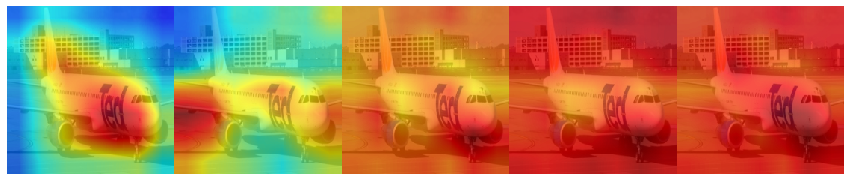

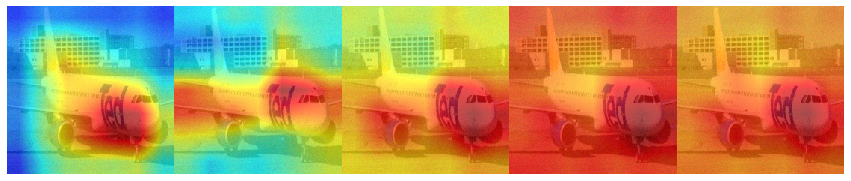

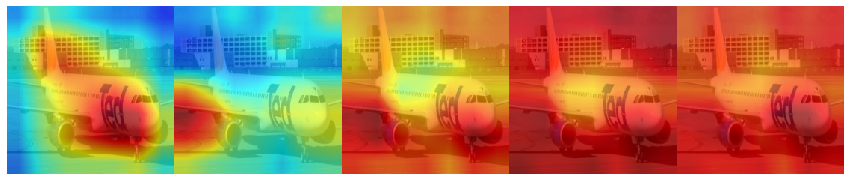

In [89]:
plot_heatmaps(range(169, 174), img)
plot_heatmaps(range(169, 174), rand_img[0])
plot_heatmaps(range(169, 174), adv_img[0])

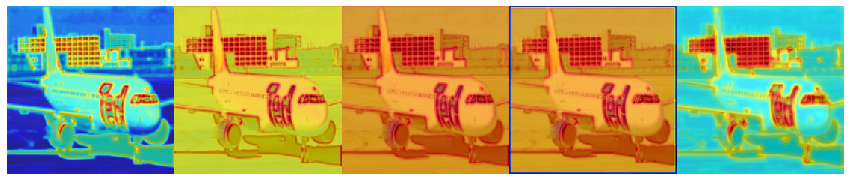

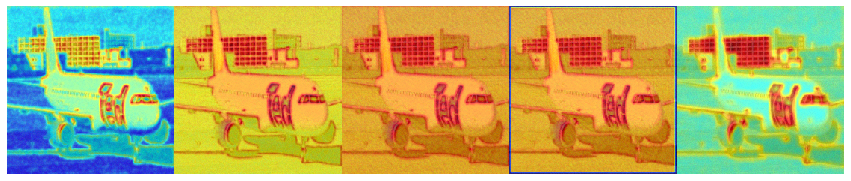

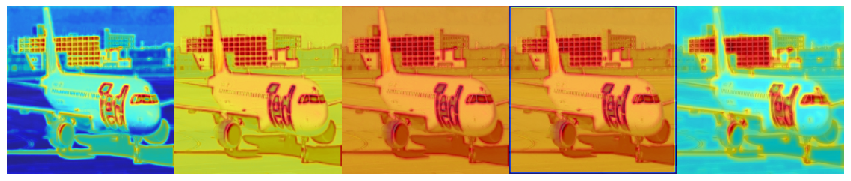

In [90]:
plot_heatmaps(range(2, 7), img)
plot_heatmaps(range(2, 7), rand_img[0])
plot_heatmaps(range(2, 7), adv_img[0])

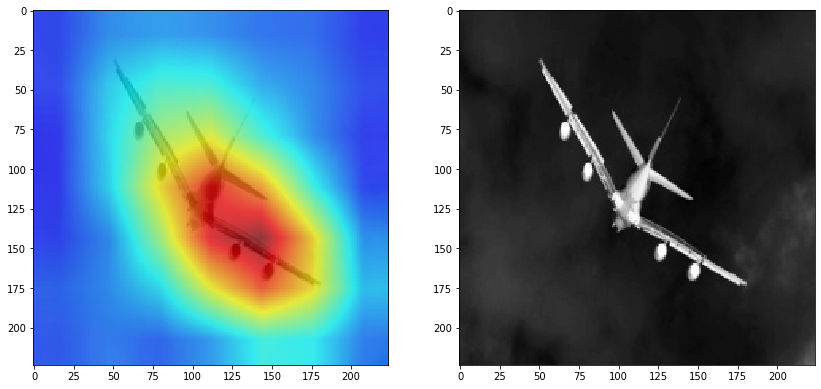

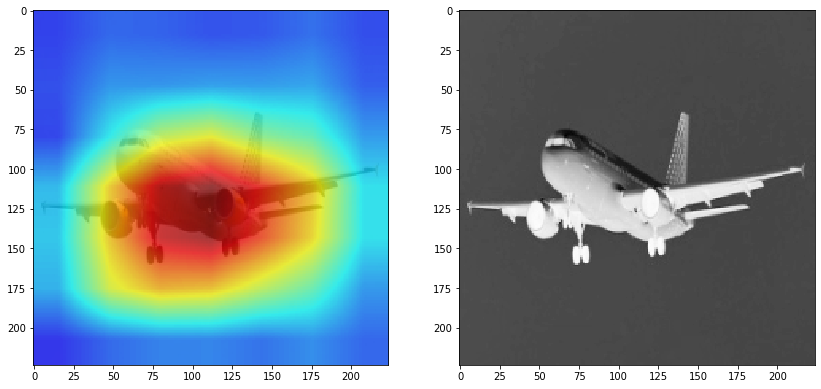

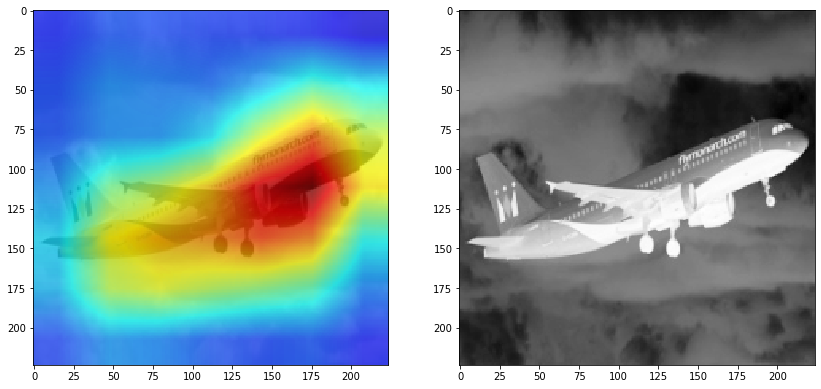

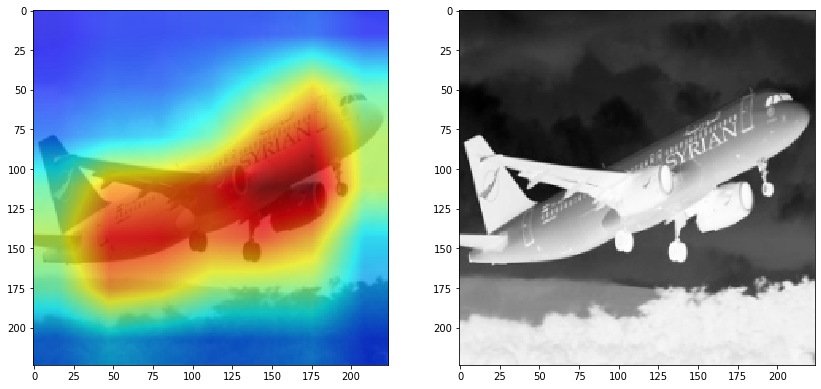

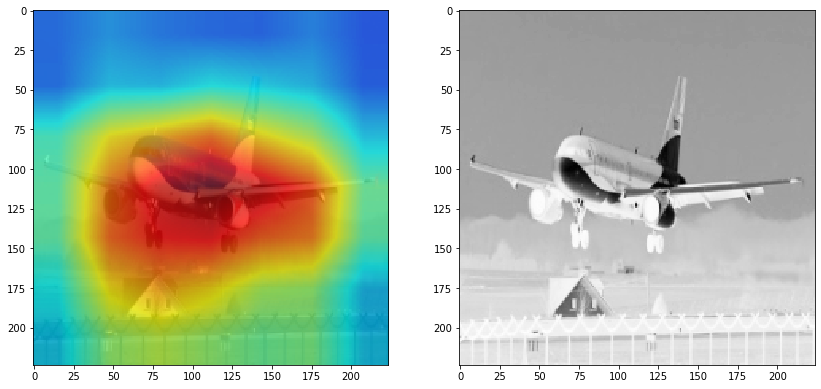

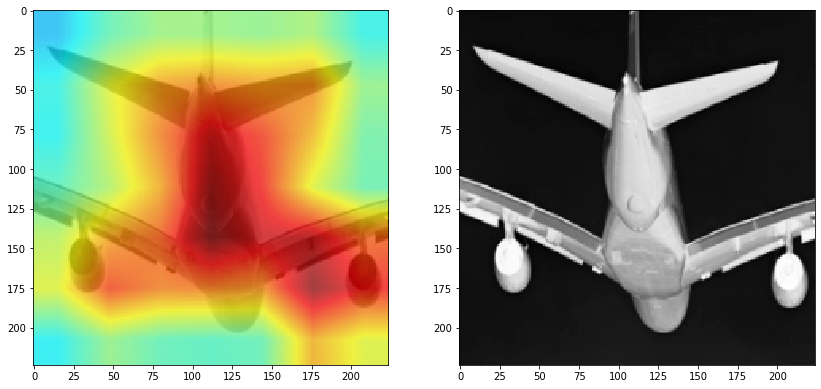

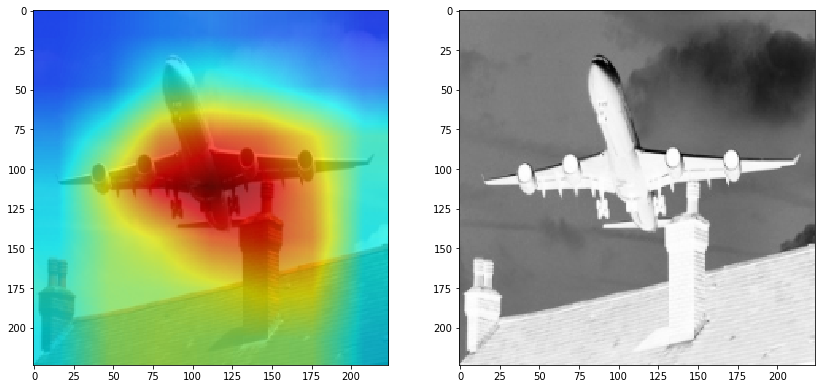

In [27]:
idxs = [0, 1, 2, 3, 7, 9, 12]

for i in idxs:
    plot_heatmaps(range(169, 170), imgs[i])